# Lending club loan data analysis

### Problem statement
- To predict whether a loan will be default or not

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
import joblib
import pickle

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### Loading dataset

In [2]:
loan_data = pd.read_csv("loan_data.csv")

# EDA
- Conducting a graphical and statistical analysis of the dataset and make some visualizations so as to understand the data

In [3]:
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
# Schema of dataset
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


### Notes
- Purpose feature is categorical hence there is need to encode it

### Statistical summary of numerical variables in the dataset

In [5]:
loan_data.describe().T

,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
int.rate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


### Graphical visualization of the distribution of features

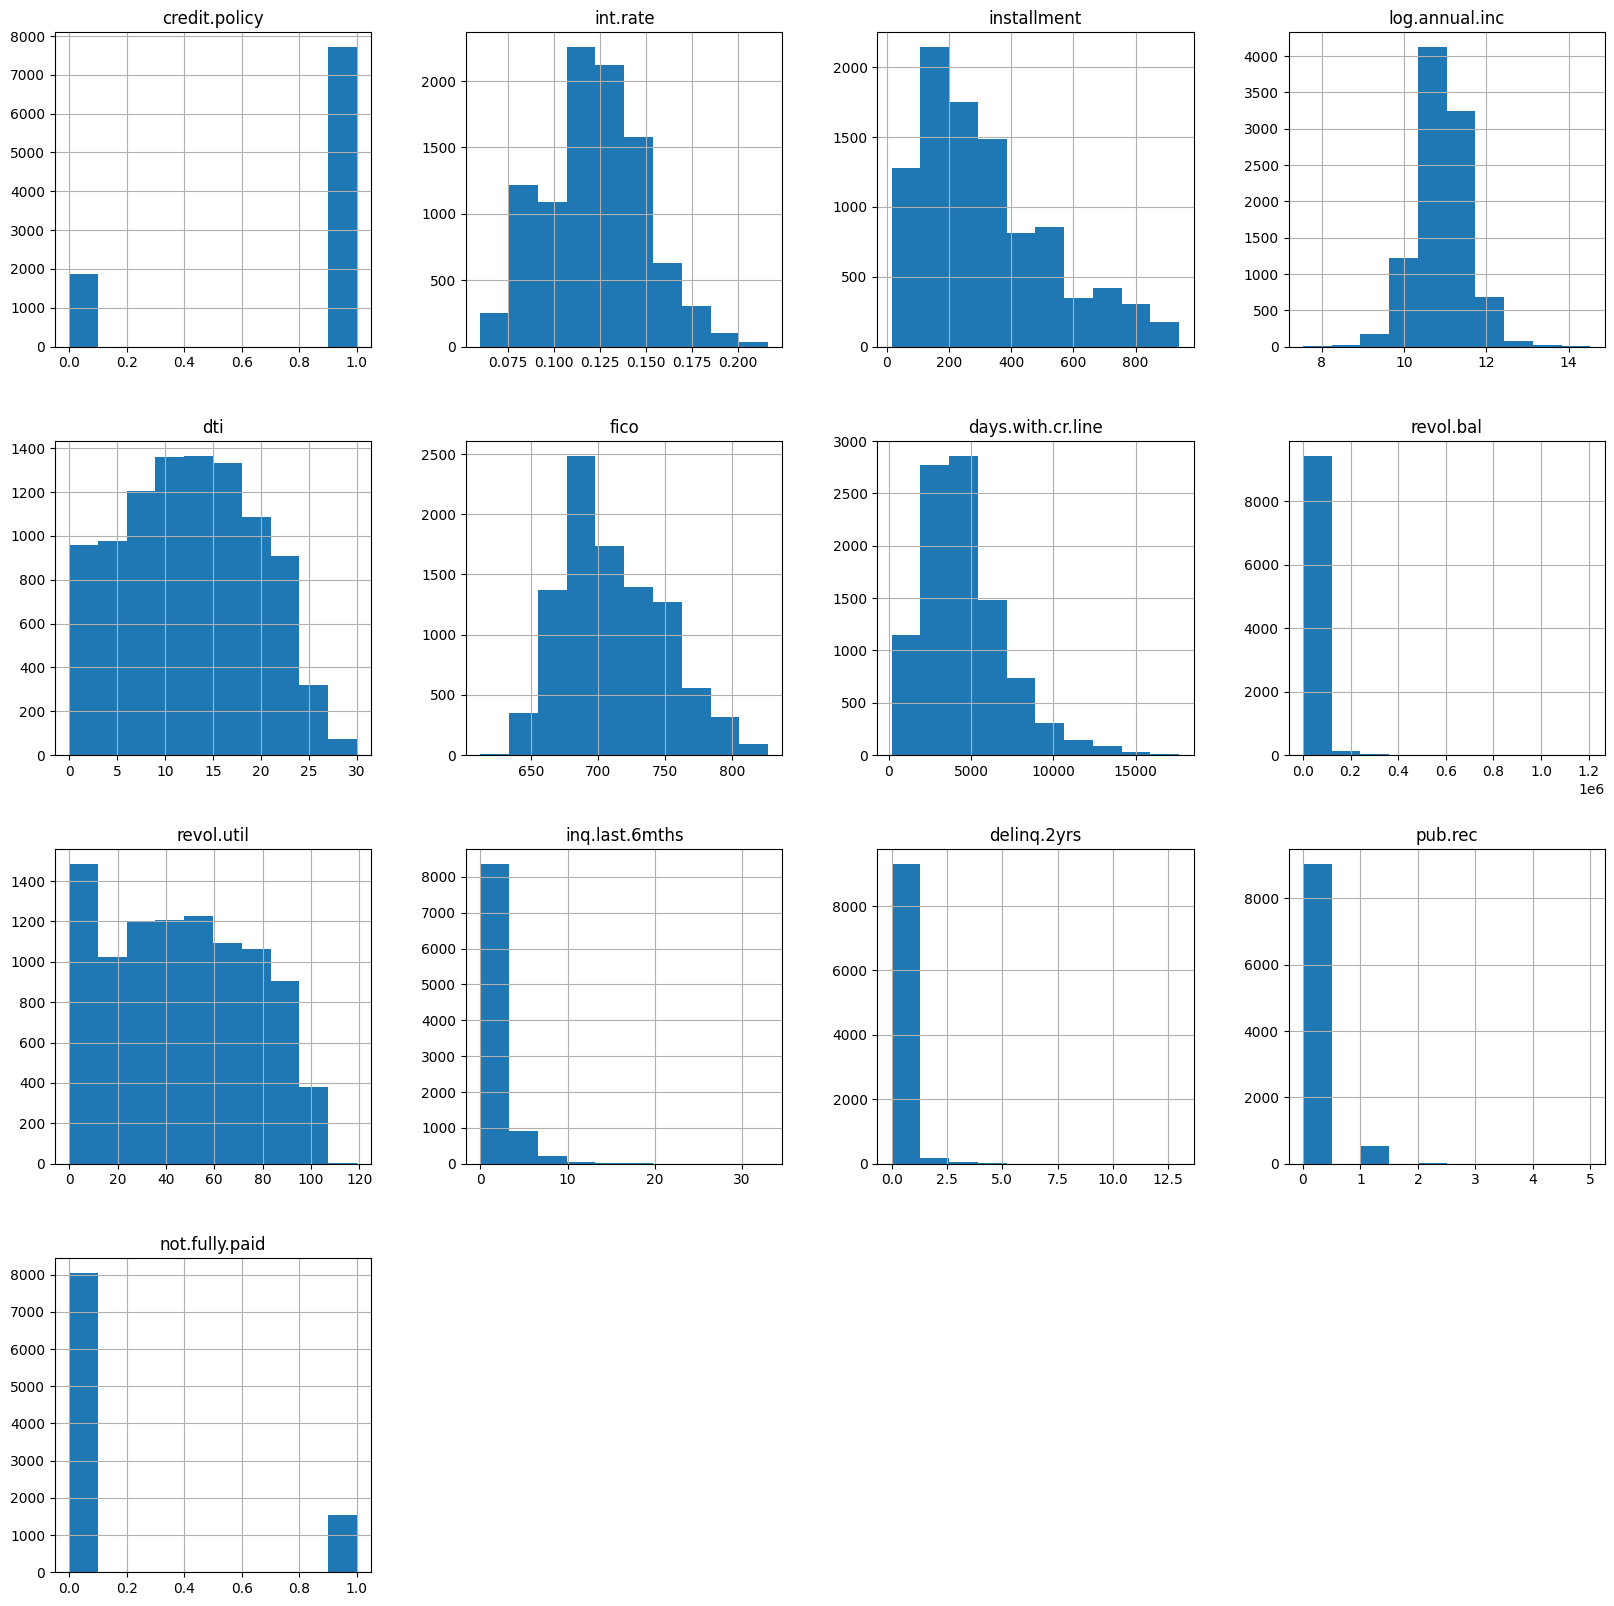

In [6]:
# Histograms of features
loan_data.hist(figsize=(20,20))
plt.show()

### Notes
-The histograms showed the distribution of features
- Fico, int.rate and log.annual.inc are normally distributed
- Logarithmic traformation can be done on the features which are skewed
- Features have different ranges of distribution hence feature scaling is a necesity  

Variables of purpose

debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: purpose, dtype: int64


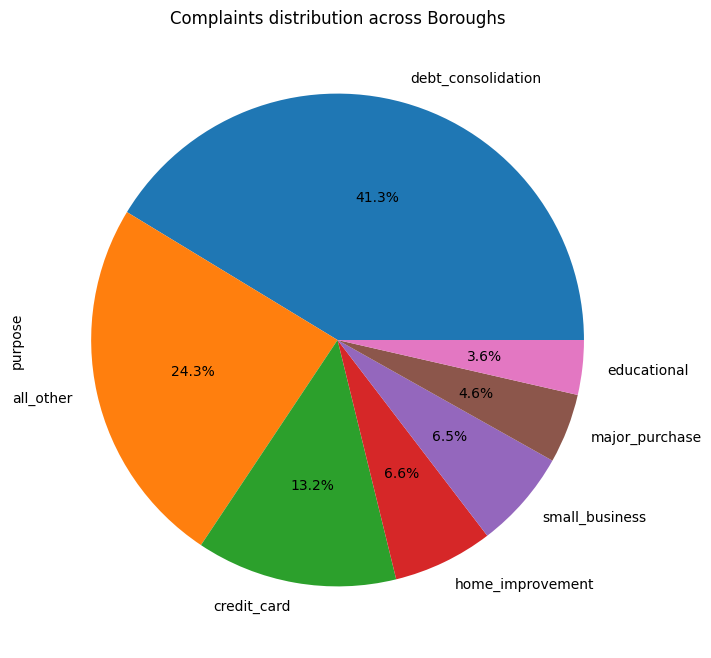

In [7]:
# Analyzing the purpose of loans feature
figure = plt.figure(figsize=(15,8))
loan_data["purpose"].value_counts().plot(kind='pie',autopct ="%1.1f%%",
                                         figsize = (10,8), title ="Complaints distribution across Boroughs")
print("Variables of purpose")
print()
print(loan_data.purpose.value_counts())
plt.show()

### Observation
- Debt_consolidation is the most frequent purpose for borrowing loan
- Educational is the least popular purpose

### Distribution of Purpose with regards to the payment status

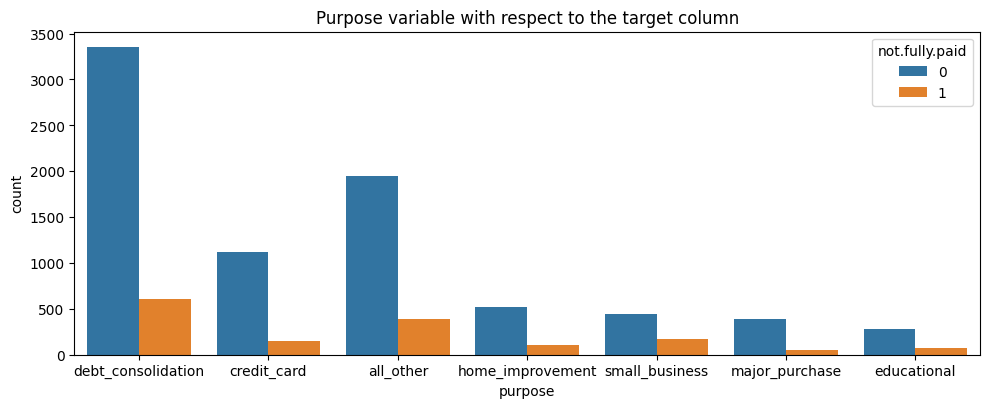

In [8]:
figure = plt.figure(figsize=(10,4))
sns.countplot(x="purpose", hue= 'not.fully.paid', data=loan_data)
plt.tight_layout()
plt.title("Purpose variable with respect to the target column")
plt.show()

### Notes
- The purpose with the most unpaid loans is debt consolidation

### Visualizing correlations on heatmap

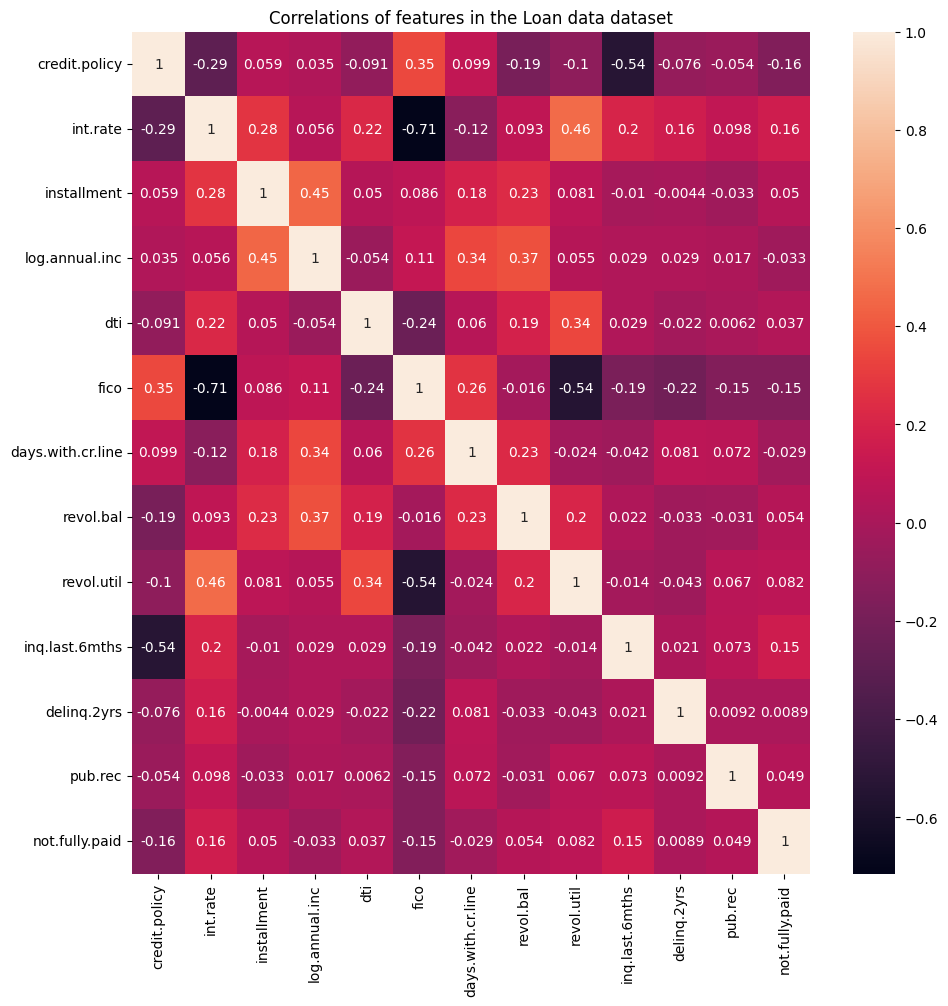

In [9]:
figure = plt.figure(figsize=(10,10))
sns.heatmap(loan_data.corr(), annot = True)
plt.tight_layout()
plt.title("Correlations of features in the Loan data dataset")
plt.show()

### Inference
- Fico and interset rate recorded the highest correlation of 71%
- There are no extreme cases of correlation hence using all the features for modelling

### Checking for outliers

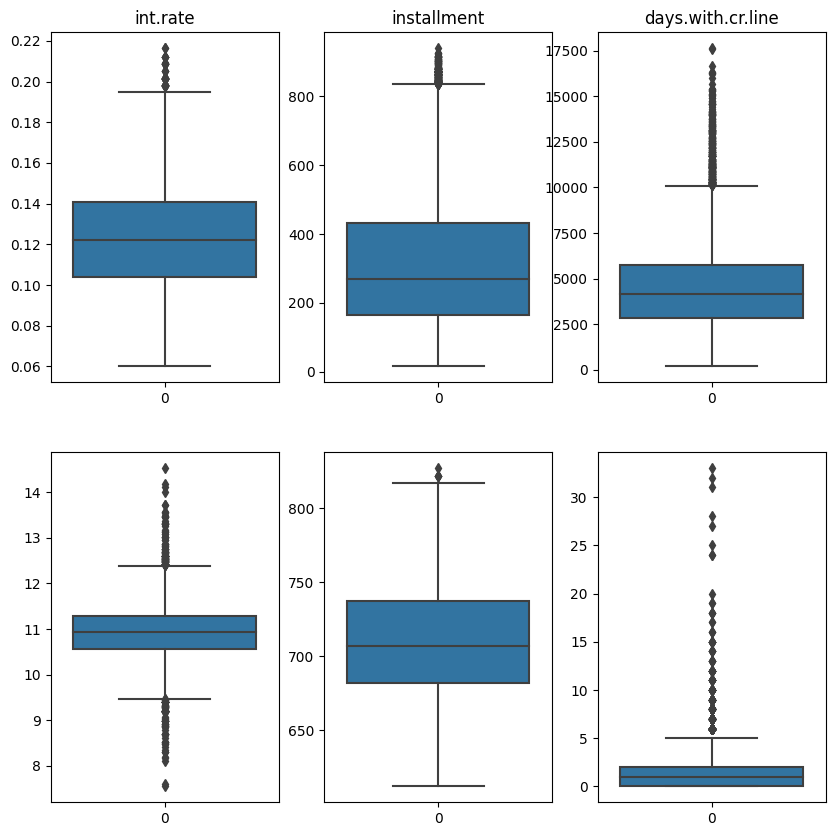

In [10]:
#Checking for outliers
figure = plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
sns.boxplot(loan_data["int.rate"])
plt.title("int.rate")

plt.subplot(2,3,2)
sns.boxplot(loan_data["installment"])
plt.title("installment")

plt.subplot(2,3,3)
sns.boxplot(loan_data["days.with.cr.line"])
plt.title("days.with.cr.line")

plt.subplot(2,3,4)
sns.boxplot(loan_data["log.annual.inc"])

plt.subplot(2,3,5)
sns.boxplot(loan_data["fico"])

plt.subplot(2,3,6)
sns.boxplot(loan_data["inq.last.6mths"])

plt.show()

# Analyzing the target column

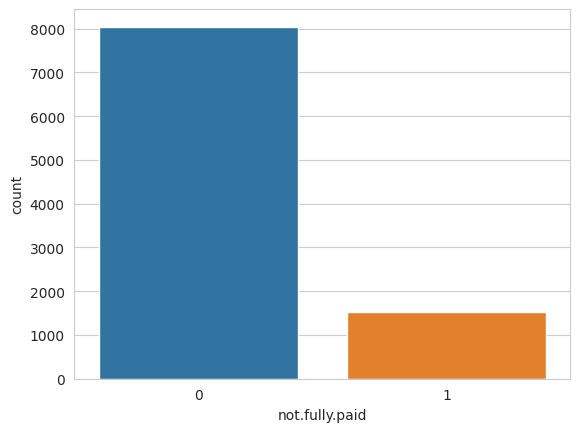

In [11]:
# Distribution of not.fully .paid column
sns.set_style("whitegrid")
sns.countplot(x='not.fully.paid', data=loan_data)
plt.show()

### Notes
- The target variable ["not.fully.paid"] is biased
- Oversampling to be done using SMOTE algorithm inorder to balance the dataset

# Data wrangling
- Cleaning data and transforming the features in preparation for data modeling

### Checking for missing numbers

In [12]:
loan_data.isna().sum().any()

False

There are no misssing values in the dataset

### Checking for duplicates

In [13]:
loan_data.duplicated().any()

False

The dataset has no duplicates

### Checking for features with 0 variance

In [14]:
loan_data.var()==0

credit.policy        False
int.rate             False
installment          False
log.annual.inc       False
dti                  False
fico                 False
days.with.cr.line    False
revol.bal            False
revol.util           False
inq.last.6mths       False
delinq.2yrs          False
pub.rec              False
not.fully.paid       False
dtype: bool

### Notes:
- All columns are informative, they have some variability since there are no columns with zero variance

## Handling outliers

- Outliers should not be automatically removed because they may be useful and bring important information to prediction models.
- However since this project is for learning purposes, I'll expore how to remove the outliers.

In [15]:
#Removing outliers
loan_data = loan_data[(loan_data['int.rate']<0.19)& (loan_data["installment"]<835)&
                       (loan_data["days.with.cr.line"]<9450)&(loan_data["fico"]<815)&
                       (loan_data["inq.last.6mths"]<5)&(loan_data["log.annual.inc"]<12.3)&
                       (loan_data["log.annual.inc"]>9.4)&(loan_data["dti"]<34)]

In [16]:
loan_data.shape

(7948, 14)

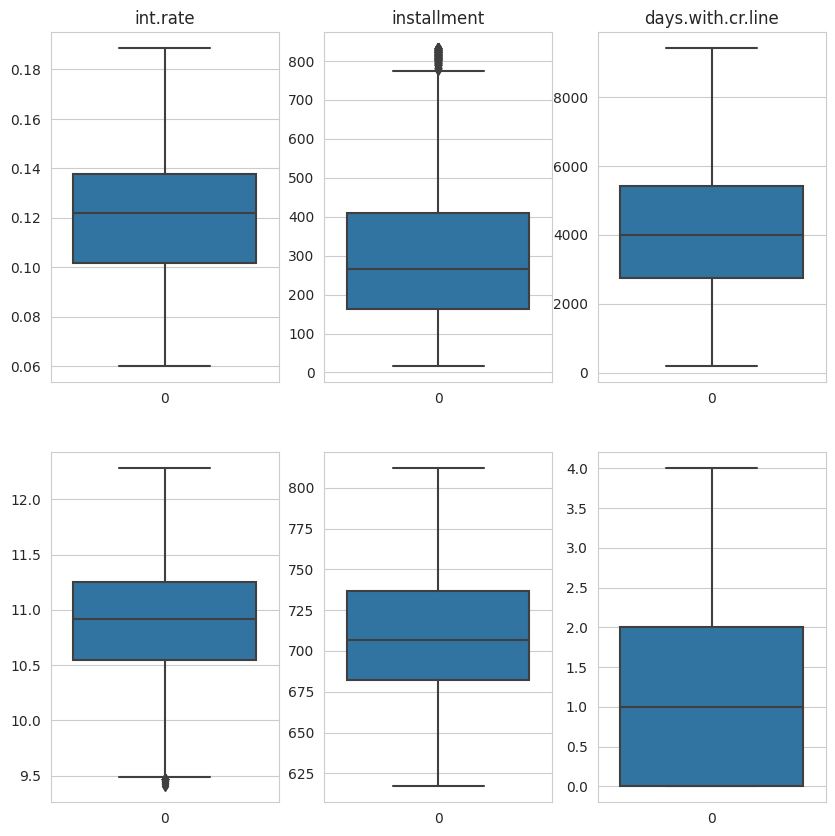

In [17]:
#Checking for outliers
figure = plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
sns.boxplot(loan_data["int.rate"])
plt.title("int.rate")

plt.subplot(2,3,2)
sns.boxplot(loan_data["installment"])
plt.title("installment")

plt.subplot(2,3,3)
sns.boxplot(loan_data["days.with.cr.line"])
plt.title("days.with.cr.line")

plt.subplot(2,3,4)
sns.boxplot(loan_data["log.annual.inc"])

plt.subplot(2,3,5)
sns.boxplot(loan_data["fico"])

plt.subplot(2,3,6)
sns.boxplot(loan_data["inq.last.6mths"])

plt.show()

There are some outliers remaining even after removing the majority of outliers

### Encoding and  scaling data

In [18]:
# X are the features and y the target feature
X = loan_data.drop(columns = ["not.fully.paid"], axis=1)
y = loan_data["not.fully.paid"]

In [19]:
categorical_columns = ['purpose']
numerical_columns = [col for col in X.columns if col not in categorical_columns]

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

In [21]:
X_processed = preprocessor.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=7)

## Balancing dataset

In [23]:
smote = SMOTE(random_state=7)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

### Notes
- Sampling techniques like smote are only applied to the training data to avoid data leakages
- That way the model evaluation will also be realistic on the unseen test data

## Traditional Machine Classifiers

## Random forest classifier

In [24]:
X_train_rcf, X_test_rcf, y_train_rcf, y_test_rcf = train_test_split(X, y, test_size=0.2, random_state=7)

In [25]:
from imblearn.pipeline import Pipeline as IMBPipeline
rfc_pipeline = make_pipeline(
    preprocessor,
    IMBPipeline([
        ('resample', SMOTE(random_state=7)),
        ('classifier',RandomForestClassifier(random_state=7))
    ])
)

In [26]:
rfc_pipeline.fit(X_train_rcf,y_train_rcf)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['credit.policy', 'int.rate',
                                                   'installment',
                                                   'log.annual.inc', 'dti',
                                                   'fico', 'days.with.cr.line',
                                                   'revol.bal', 'revol.util',
                                                   'inq.last.6mths',
                                                   'delinq.2yrs', 'pub.rec']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['purpose'])])),
                ('pipeline',
                 Pipeline(steps=[('resample', SMOTE(random_state=7)),
                                 ('classifier',
                                  RandomForestClassifier(random_state=7))]))])

In [27]:
rfc_predictions = rfc_pipeline.predict(X_test_rcf)

In [28]:
report = classification_report(y_test_rcf, rfc_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1354
           1       0.24      0.12      0.16       236

    accuracy                           0.81      1590
   macro avg       0.55      0.53      0.53      1590
weighted avg       0.77      0.81      0.79      1590



### Logistic regression

In [29]:
lr_model = LogisticRegression(random_state=7)

In [30]:
lr_model = lr_model.fit(X_train_balanced, y_train_balanced)

In [31]:
y_pred = lr_model.predict(X_test)

In [32]:
print('Logistic regresion: ', accuracy_score(y_test,y_pred.round()))


Logistic regresion:  0.6176100628930817


# SVM

In [33]:
svc_model = SVC(random_state=7)

In [34]:
svc_model = svc_model.fit(X_train_balanced, y_train_balanced)

In [35]:
svc_predictions = svc_model.predict(X_test)

In [36]:
print('SVC accuracy score: ', accuracy_score(y_test,svc_predictions))

SVC accuracy score:  0.5685534591194968


# XGBOOST

In [37]:
xgb_model = XGBClassifier(random_state=7)

In [38]:
xgb_model = xgb_model.fit(X_train_balanced, y_train_balanced)

In [39]:
xgb_predictions = xgb_model.predict(X_test)

In [40]:
print('XG boost accuracy score: ', accuracy_score(y_test,xgb_predictions))

XG boost accuracy score:  0.8169811320754717


# Using cross validation and some hyper parameter tuning

### Notes
- Cross-validation is used in hyperparameter tuning to estimate the performance of each hyperparameter configuration.
- It helps prevent overfitting hyperparameters to a specific train-test split, ensuring the chosen hyperparameters generalize well to new data.

In [41]:
cv_scores = cross_val_score(xgb_model, X_train_balanced, y_train_balanced, cv=5)

In [42]:
print("Cross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Scores:
[0.63499315 0.93878483 0.93144424 0.95292505 0.94149909]
Mean Accuracy: 0.88


In [43]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

In [44]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    random_state=7
)

In [45]:
random_search.fit(X_train_balanced, y_train_balanced)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=7, ...),
                   param_distributions={'classifier__learning_rate': [0.1, 0.01,
                                                                      0.001],
                                        'classifier__max_depth': [3, 5, 7],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=7, scoring='accuracy')

In [46]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'classifier__n_estimators': 300, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
Best Score: 0.8799292707512967


## Checking the accuracy of the best parameters

In [47]:
best_xgb_model =XGBClassifier(n_estimators=300, max_depth =3, learning_rate= 0.1)

In [48]:
best_xgb_model.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [49]:
best_xgb_predictions = best_xgb_model.predict(X_test)

In [50]:
print('XG boost with hyper parameter tuning accuracy score is : ', accuracy_score(y_test,best_xgb_predictions))

XG boost with hyper parameter tuning accuracy score is :  0.8377358490566038


# Model persistence

### Joblib

In [51]:
joblib.dump(best_xgb_model, 'loan_classifier.joblib')

['loan_classifier.joblib']

In [52]:
#Loading model later
model = joblib.load('loan_classifier.joblib')

In [53]:
# Making predictions using the loaded model
predictions = model.predict(X_test)


### Pickling

In [54]:
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [55]:
with open('best_xgb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


In [56]:
# Make predictions using the loaded model
predictions = loaded_model.predict(X_test)